In [8]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import yfinance as yf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Datasets de Bolsa de Valores - SP500


In [9]:
#Guarda los valores de una accion en particular(ticke), de un periodo de tiempo en un dataframe
#este caso es el Standard & Poor's 500 - S&P500
sp500_10y = yf.Ticker("^GSPC").history(period="10y")

#Mestra la cabecera del dataframe
sp500_10y.head(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2014-09-16 00:00:00-04:00,1981.930054,2002.280029,1979.060059,1998.979980,3160310000,0.0,0.0
2014-09-17 00:00:00-04:00,1999.300049,2010.739990,1993.290039,2001.569946,3209420000,0.0,0.0
2014-09-18 00:00:00-04:00,2003.069946,2012.339966,2003.069946,2011.359985,3235340000,0.0,0.0
2014-09-19 00:00:00-04:00,2012.739990,2019.260010,2006.589966,2010.400024,4880220000,0.0,0.0
2014-09-22 00:00:00-04:00,2009.079956,2009.079956,1991.010010,1994.290039,3349670000,0.0,0.0


# Red LSTM 

In [10]:
# Fijamos la semilla para asegurar que los resultados de las operaciones aleatorias sean reproducibles.
np.random.seed(4)

# Dividimos los datos en un conjunto de entrenamiento (hasta el año 2022) y un conjunto de validación (a partir de 2023).
# Usamos solo la segunda columna del dataset (precio de cierre).
set_entrenamiento = sp500_10y[:'2022'].iloc[:, 1:2]
set_validacion = sp500_10y['2023':].iloc[:, 1:2]

# Escalamos los datos de entrenamiento para que estén en el rango de 0 a 1.
# Esto es importante para mejorar el rendimiento de los algoritmos de machine learning.
sc = MinMaxScaler(feature_range=(0, 1))
set_entrenamiento_escalado = sc.fit_transform(set_entrenamiento)

# Definimos la longitud de la ventana de tiempo (60 días).
time_step = 60
X_train = []  # Lista para almacenar las secuencias de entrada.
Y_train = []  # Lista para almacenar los valores objetivo.
m = len(set_entrenamiento_escalado)  # Número total de datos en el conjunto de entrenamiento escalado.

# Creamos las secuencias de entrada (X_train) y los valores objetivo (Y_train).
# Para cada ventana de 60 días (time_step), el valor objetivo es el día siguiente.
for i in range(time_step, m):
    # La secuencia de entrada X: contiene datos de 60 días previos.
    X_train.append(set_entrenamiento_escalado[i-time_step:i, 0])

    # El valor objetivo Y: el valor del día siguiente.
    Y_train.append(set_entrenamiento_escalado[i, 0])

# Convertimos las listas a arrays numpy para que puedan ser usados por TensorFlow.
X_train, Y_train = np.array(X_train), np.array(Y_train)

# Reestructuramos X_train para que tenga la forma adecuada para el modelo LSTM: (n_samples, time_steps, n_features).
# Donde n_samples es el número de muestras, time_steps es la longitud de la secuencia, y n_features es el número de características (en este caso, 1).
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Definimos las dimensiones de entrada y salida para la LSTM.
dim_entrada = (X_train.shape[1], 1)  # Entrada con 60 pasos de tiempo y 1 característica.
dim_salida = 1  # Salida de una sola variable (el valor predicho).

# Definimos el número de neuronas en la capa LSTM.
na = 50

# Creamos el modelo secuencial.
modelo = Sequential()

# Añadimos una capa LSTM con 'na' neuronas y la forma de entrada especificada.
modelo.add(LSTM(units=na, input_shape=dim_entrada))

# Añadimos una capa densa de salida con una única neurona, ya que estamos prediciendo un solo valor.
modelo.add(Dense(units=dim_salida))

# Compilamos el modelo usando el optimizador RMSprop y la función de pérdida MSE (error cuadrático medio).
# MSE es apropiado para tareas de regresión.
modelo.compile(optimizer='rmsprop', loss='mse')

# Entrenamos el modelo con el conjunto de entrenamiento durante 20 épocas, usando un tamaño de lote de 32.
modelo.fit(X_train, Y_train, epochs=20, batch_size=32)

# Para las predicciones, tomamos los valores del conjunto de validación.
x_test = set_validacion.values

# Escalamos los datos de validación para que estén en el mismo rango que los de entrenamiento.
x_test = sc.transform(x_test)

# Creamos las secuencias de entrada (X_test) para el conjunto de validación.
X_test = []
for i in range(time_step, len(x_test)):
    # Para cada ventana de 60 días en los datos de validación.
    X_test.append(x_test[i-time_step:i, 0])

# Convertimos la lista a un array numpy.
X_test = np.array(X_test)

# Reestructuramos X_test a la forma adecuada para la LSTM: (n_samples, time_steps, n_features).
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Realizamos predicciones usando el modelo entrenado.
prediccion = modelo.predict(X_test)

# Invertimos la escala de las predicciones para devolverlas a su rango original (antes de escalar).
prediccion = sc.inverse_transform(prediccion)


Epoch 1/20


c:\Users\jrgui\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - loss: 0.0227
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0011
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 8.6810e-04
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 6.9748e-04
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 6.4455e-04
Epoch 6/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 5.8232e-04
Epoch 7/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 5.3354e-04
Epoch 8/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 5.0784e-04
Epoch 9/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 4.5907e-04
Epoch 10/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 4.3952e-04
Epoch 11/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 4.0252e-04
Epoch 12/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 4.4536e-04
Epoch 13/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 3.1426e-04
Epoch 14/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 3.5289e-04
Epoch 15/20
64/64 ━━━━━━━━━━━━━━━━

c:\Users\jrgui\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step


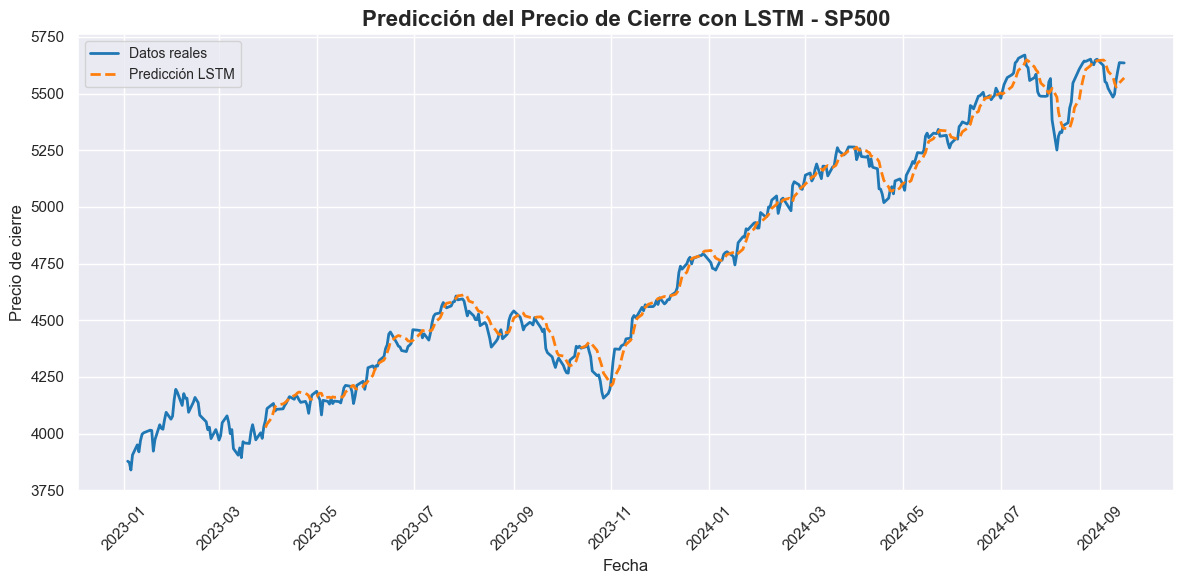

In [11]:
# Añadimos una nueva columna 'Prediccion' al conjunto de validación, inicializando sus valores como NaN.
set_validacion['Prediccion'] = np.nan
set_validacion['Prediccion'].iloc[time_step:] = prediccion.flatten()

# Establecemos el estilo de Seaborn para gráficos más estéticos
sns.set_theme(style="darkgrid")  # Configuración similar a 'seaborn-darkgrid'
#sns.set_style(style="dark")  # Configuración similar a 'seaborn-darkgrid'


# Gráfico 1: Datos reales de validación vs predicción usando Seaborn
plt.figure(figsize=(12,6))

# Colores personalizados
color_real = '#1f77b4'   # Azul suave
color_pred = '#ff7f0e'   # Naranja suave

# Graficamos los datos reales de validación con Seaborn.
sns.lineplot(x=set_validacion.index, y=set_validacion.iloc[:, 0], color=color_real, label='Datos reales', linewidth=2)

# Graficamos las predicciones del modelo LSTM con Seaborn.
sns.lineplot(x=set_validacion.index, y=set_validacion['Prediccion'], color=color_pred, label='Predicción LSTM', linestyle='--', linewidth=2)

# Añadimos título y etiquetas a los ejes del gráfico.
plt.title('Predicción del Precio de Cierre con LSTM - SP500', fontsize=16, fontweight='bold')
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Precio de cierre', fontsize=12)

# Añadimos una leyenda para identificar cada curva.
plt.legend(loc='upper left', fontsize=10)

# Ajustamos el espaciado de las etiquetas en el eje X.
plt.xticks(rotation=45)

# Ajuste de márgenes para que no se sobrepongan elementos.
plt.tight_layout()

# Mostramos el gráfico.
plt.show()


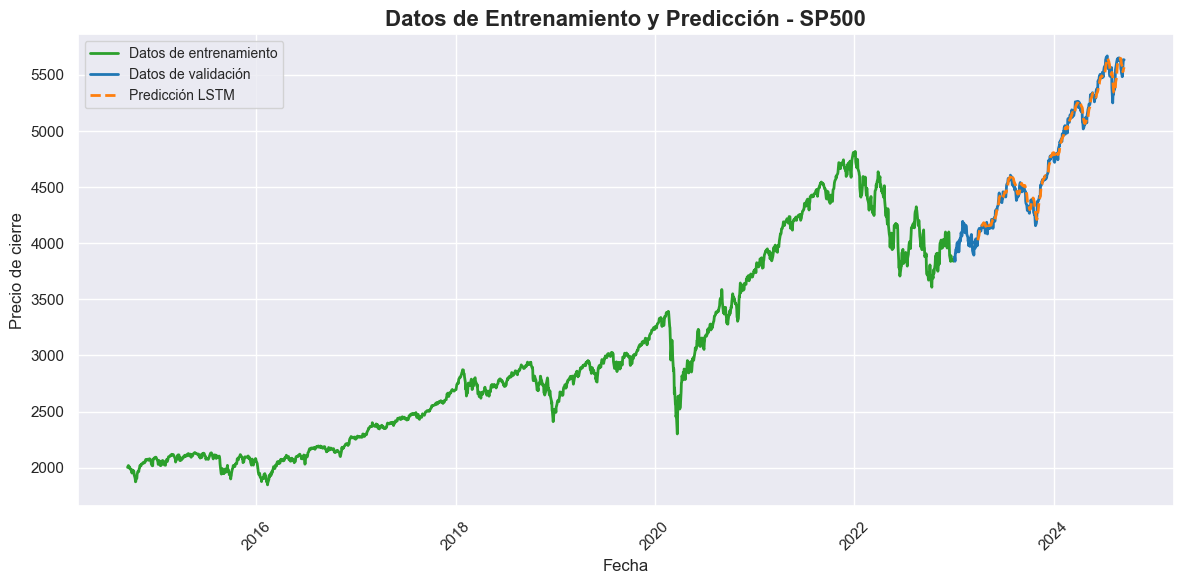

In [12]:
# Definimos el tamaño del conjunto de entrenamiento y validación.
train_size = len(set_entrenamiento)
valid_size = len(set_validacion)

# Combinamos los datos de entrenamiento y validación en un solo dataframe para que se puedan graficar juntos.
dataset_total = pd.concat([set_entrenamiento, set_validacion], axis=0)

# Establecemos el estilo de Seaborn para gráficos más estéticos.
sns.set_theme(style="darkgrid")  # Configuración similar a 'seaborn-darkgrid'

# Colores personalizados.
color_train = '#2ca02c'  # Verde suave
color_valid = '#1f77b4'  # Azul suave
color_pred = '#ff7f0e'   # Naranja suave

# Gráfico 2: Datos de entrenamiento, datos de validación y predicciones.
plt.figure(figsize=(12,6))

# Graficamos los datos de entrenamiento.
sns.lineplot(x=dataset_total.index[:train_size], y=dataset_total.iloc[:train_size, 0], color=color_train, label='Datos de entrenamiento', linewidth=2)

# Graficamos los datos de validación.
sns.lineplot(x=dataset_total.index[train_size:], y=dataset_total.iloc[train_size:, 0], color=color_valid, label='Datos de validación', linewidth=2)

# Graficamos las predicciones del modelo a partir del índice `train_size + time_step`.
sns.lineplot(x=dataset_total.index[train_size+time_step:], y=set_validacion['Prediccion'].dropna(), color=color_pred, label='Predicción LSTM', linestyle='--', linewidth=2)

# Añadimos título y etiquetas a los ejes del gráfico.
plt.title('Datos de Entrenamiento y Predicción - SP500', fontsize=16, fontweight='bold')
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Precio de cierre', fontsize=12)

# Añadimos una leyenda para identificar cada curva.
plt.legend(loc='upper left', fontsize=10)

# Ajustamos el espaciado de las etiquetas en el eje X.
plt.xticks(rotation=45)

# Ajuste de márgenes para que no se sobrepongan elementos.
plt.tight_layout()

# Mostramos el gráfico.
plt.show()
